In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

## 1、构建简单的网络
### 1.1 创建网络

In [17]:
inputs = tf.keras.Input(shape=(784,), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist model')

In [18]:
model.summary()

Model: "mnist model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 27,882
Trainable params: 27,882
Non-trainable params: 0
_________________________________________________________________


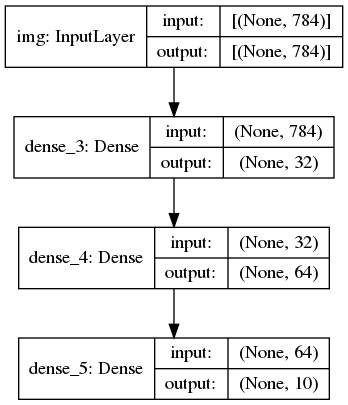

In [19]:
keras.utils.plot_model(model, './models/minst_model.png')
keras.utils.plot_model(model, './models/minst_info.png', show_shapes='True')

### 1.2 验证及测试
使用 mnist 数据集进行测试，进对数据进行相同的处理

In [20]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

In [21]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])

In [22]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5


ValueError: in user code:

    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1006 __call__
        with ops.name_scope_v2(name_scope):
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:6650 __enter__
        scope_name = scope.__enter__()
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/contextlib.py:112 __enter__
        return next(self.gen)
    /home/xia/miniconda3/envs/20210331_tf_quantize/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:4246 name_scope
        raise ValueError("'%s' is not a valid scope name" % name)

    ValueError: 'mnist model/' is not a valid scope name


In [23]:
encode_input = keras.Input(shape=(28,28,1),name='image') # 输入28*28的灰度图像
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)# 2维的卷积层，fliter数目为16，window_size为3
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)
encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name="encoder")
encode_model.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [24]:
decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2) # 反卷积
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2) # 超采样
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 6, 6, 16)          160       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         145 

In [2]:
from tensorflow.keras.applications import VGG16
vgg16=VGG16()

feature_list = [layer.output for layer in vgg16.layers]
feat_ext_model = keras.Model(inputs=vgg16.input, outputs=feature_list)

img = np.random.random((1, 224, 224, 3).astype('float32'))
ext_features = feat_ext_model(img)

172171264/553467096 [========>.....................] - ETA: 51s

KeyboardInterrupt: 